# Deep Learning with Torch: the 60-minute blitz

Based on http://nbviewer.ipython.org/github/soumith/talks/blob/master/gtc2015/Deep%20Learning%20with%20Torch.ipynb by Soumith Chintala


###Goal of this talk
* Understand torch and the neural networks package at a high-level.
* Train a small neural network on CPU and GPU

##What is Torch?

Torch is an scientific computing framework based on Lua[JIT] with strong CPU and CUDA backends.

Strong points of Torch:

* Efficient Tensor library (like NumPy) with an efficient CUDA backend
* Neural Networks package -- build arbitrary acyclic computation graphs with automatic differentiation
   * also with fast CUDA and CPU backends
* Good community and industry support - several hundred community-built and maintained packages.
* Easy to use Multi-GPU support and parallelizing neural networks

http://torch.ch  
https://github.com/torch/torch7/wiki/Cheatsheet

##Before getting started

* Based on Lua and runs on Lua-JIT (Just-in-time compiler) which is fast
* Lua is pretty close to javascript.
   * variables are global by default, unless `local` keyword is used
* Only has one data structure built-in, a table: `{}`. Doubles as a hash-table and an array.
* 1-based indexing.
* `foo:bar()` is the same as `foo.bar(foo)`

##Getting Started
#### Strings, numbers, tables - a tiny introduction

In [1]:
a = 'hello'

In [2]:
print(a)

hello	


In [4]:
b = {}

In [5]:
b[1] = a

In [6]:
print(b)

{
  1 : hello
}


In [7]:
b[2] = 30

In [8]:
for i=1,#b do -- the # operator is the length operator in Lua
    print(b[i]) 
end

hello	
30	


####Tensors

In [1]:
a = torch.Tensor(5,3) -- construct a 5x3 matrix, uninitialized

In [2]:
a = torch.rand(5,3)
print(a)

 0.1021  0.2428  0.6334
 0.6574  0.6234  0.0170
 0.3294  0.1679  0.3694
 0.0123  0.7631  0.6857
 0.3726  0.7268  0.0870
[torch.DoubleTensor of size 5x3]



In [3]:
b=torch.rand(3,4)

In [4]:
-- matrix-matrix multiplication: syntax 1
a*b 

 0.1776  0.7878  0.3004  0.5442
 0.8041  0.7179  0.7229  0.3376
 0.3641  0.5756  0.3586  0.3518
 0.2515  1.1932  0.5074  0.7974
 0.5697  0.7566  0.6063  0.4056
[torch.DoubleTensor of size 5x4]



In [5]:
-- matrix-matrix multiplication: syntax 2
torch.mm(a,b) 

 0.1776  0.7878  0.3004  0.5442
 0.8041  0.7179  0.7229  0.3376
 0.3641  0.5756  0.3586  0.3518
 0.2515  1.1932  0.5074  0.7974
 0.5697  0.7566  0.6063  0.4056
[torch.DoubleTensor of size 5x4]



In [6]:
-- matrix-matrix multiplication: syntax 3
c=torch.Tensor(5,4)
c:mm(a,b) -- store the result of a*b in c

####CUDA Tensors
Tensors can be moved onto GPU using the :cuda function

In [7]:
require 'cutorch';
a = a:cuda()
b = b:cuda()
c = c:cuda()
c:mm(a,b) -- done on GPU

### Neural Networks
Neural networks in Torch can be constructed using the `nn` package.

In [1]:
require 'nn';

`Modules` are the bricks used to build neural networks. Each are themselves neural networks, but can be combined with other networks using `containers` to create complex neural networks

For example, look at this network that classfies digit images:
![LeNet](http://fastml.com/images/cifar/lenet5.png)

It is a simple feed-forward network.   
It takes the input, feeds it through several layers one after the other, and then finally gives the output.

Such a network container is `nn.Sequential` which feeds the input through several layers.

In [21]:
net = nn.Sequential()
net:add(nn.SpatialConvolution(1, 6, 5, 5))  -- 1 input image channel, 6 output channels, 5x5 convolution kernel
net:add(nn.SpatialMaxPooling(2,2,2,2))      -- A max-pooling operation that looks at 2x2 windows and finds the max.
net:add(nn.SpatialConvolution(6, 16, 5, 5))
net:add(nn.SpatialMaxPooling(2,2,2,2))
net:add(nn.View(16*5*5))                    -- reshapes from a 3D tensor of 16x5x5 into 1D tensor of 16*5*5
net:add(nn.Linear(16*5*5, 120))             -- fully connected layer (matrix multiplication between input and weights)
net:add(nn.Linear(120, 84))
net:add(nn.Linear(84, 10))                   -- 10 is the number of outputs of the network (in this case, 10 digits)
net:add(nn.LogSoftMax())                     -- converts the output to a log-probability. Useful for classification problems

print('Lenet5\n' .. net:__tostring());

Lenet5
nn.Sequential {
  [input -> (1) -> (2) -> (3) -> (4) -> (5) -> (6) -> (7) -> (8) -> (9) -> output]
  (1): nn.SpatialConvolution
  (2): nn.SpatialMaxPooling
  (3): nn.SpatialConvolution
  (4): nn.SpatialMaxPooling
  (5): nn.View
  (6): nn.Linear(400 -> 120)
  (7): nn.Linear(120 -> 84)
  (8): nn.Linear(84 -> 10)
  (9): nn.LogSoftMax
}	


Other examples of nn containers are shown in the figure below:
![containers](https://raw.githubusercontent.com/soumith/ex/gh-pages/assets/nn_containers.png)

Every neural network module in torch has automatic differentiation.
It has a `:forward(input)` function that computes the output for a given input, flowing the input through the network.
and it has a `:backward(input, gradient)` function that will differentiate each neuron in the network w.r.t. the gradient that is passed in. This is done via the chain rule.

In [ ]:
input = torch.rand(1,32,32) -- pass a random tensor as input to the network

In [ ]:
output = net:forward(input)

In [ ]:
print(output)

In [ ]:
net:zeroGradParameters() -- zero the internal gradient buffers of the network (will come to this later)

In [ ]:
gradInput = net:backward(input, torch.rand(10))

In [ ]:
print(#gradInput)

### Criterion: Defining a loss function
When you want a model to learn to do something, you give it feedback on how well it is doing. This function that computes an objective measure of the model's performance is called a __loss function__.

A typical loss function takes in the model's output and the groundtruth and computes a value that quantifies the model's performance.

The model then corrects itself to have a smaller loss.

In torch, loss functions are implemented just like neural network modules, and have automatic differentiation.  
They have two functions - `forward(input, target)`, `backward(input, target)`

For example:

In [ ]:
criterion = nn.ClassNLLCriterion() -- a negative log-likelihood criterion for multi-class classification
criterion:forward(output, 3) -- let's say the groundtruth was class number: 3
gradients = criterion:backward(output, 3)

In [ ]:
gradInput = net:backward(input, gradients)

#####Review of what you learnt so far
* Network can have many layers of computation
* Network takes an input and produces an output in the :forward pass
* Criterion computes the loss of the network, and it's gradients w.r.t. the output of the network.
* Network takes an (input, gradients) pair in it's backward pass and calculates the gradients w.r.t. each layer (and neuron) in the network.

##### Missing details
> A neural network layer can have learnable parameters or not.

A convolution layer learns it's convolution kernels to adapt to the input data and the problem being solved.  
A max-pooling layer has no learnable parameters. It only finds the max of local windows.

A layer in torch which has learnable weights, will typically have fields .weight (and optionally, .bias)

In [75]:
m = nn.SpatialConvolution(1,3,2,2) -- learn 3 2x2 kernels
print(m.weight) -- initially, the weights are randomly initialized

(1,1,.,.) = 
  0.1409 -0.3583
  0.2189 -0.3830

(2,1,.,.) = 
  0.3607  0.2676
  0.1334 -0.1417

(3,1,.,.) = 
  0.0828 -0.0499
  0.0147  0.4455
[torch.DoubleTensor of size 3x1x2x2]



In [76]:
print(m.bias) -- The operation in a convolution layer is: output = convolution(input,weight) + bias

 0.4380
 0.3594
 0.4146
[torch.DoubleTensor of size 3]



There are also two other important fields in a learnable layer. The gradWeight and gradBias.
The gradWeight accumulates the gradients w.r.t. each weight in the layer, and the gradBias, w.r.t. each bias in the layer.

#### Training the network

For the network to adjust itself, it typically does this operation (if you do Stochastic Gradient Descent):
> weight = weight + learningRate * gradWeight [equation 1]

This update over time will adjust the network weights such that the output loss is decreasing.

___
#Full Example - Training a ConvNet on Cifar10

__We have 5 steps left to do in training our first torch neural network__
1. Load and normalize data
2. Define Neural Network
3. Define Loss function
4. Train network on training data
5. Test network on test data.


##__1. Load and normalize data__
Generally, when you have to deal with image, text, audio or video data, you can use standard functions like: [__image.load__](https://github.com/torch/image#res-imageloadfilename-depth-tensortype) or [__audio.load__](https://github.com/soumith/lua---audio#usage) to load your data into a _torch.Tensor_ or a Lua table, as convenient.

We shall use the CIFAR-10 dataset, which has the classes: 'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'.  
The images in CIFAR-10 are of size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.
![CIFAR-10 image](https://raw.githubusercontent.com/soumith/ex/gh-pages/assets/cifar10.png)

The dataset has 50,000 training images and 10,000 test images in total.



Today, in the interest of time, we prepared the data before-hand into a 4D torch ByteTensor of size 10000x3x32x32 (training) and 10000x3x32x32 (testing)
Let us load the data and inspect it.

In [1]:
trainset = torch.load('/home/ehoffer/Datasets/Cifar10/cifar10-train.t7')
testset = torch.load('/home/ehoffer/Datasets/Cifar10/cifar10-test.t7')

classes = {'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'}

function shuffle(data,ydata) --shuffle data function
    local RandOrder = torch.randperm(data:size(1)):long()
    return data:index(1,RandOrder), ydata:index(1,RandOrder)
end


trainset.data,trainset.label = shuffle(trainset.data,trainset.label)
trainset.data = trainset.data:float() -- convert the data from a ByteTensor to a float Tensor.
trainset.label = trainset.label:float():add(1)

testset.data = testset.data:float()
testset.label = testset.label:float():add(1)

In [2]:
print(trainset)

{
  data : FloatTensor - size: 50000x3x32x32
  label : FloatTensor - size: 50000
}


For fun, let us display an image:

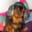

dog	


In [3]:
itorch.image(trainset.data[100]) -- display the 100-th image in dataset
print(classes[trainset.label[100]])

__One of the most important things you can do in conditioning your data (in general in data-science or machine learning) is to make your data to have a mean of 0.0 and standard-deviation of 1.0.__

Let us do that as a final step of our data processing.

To do this, we introduce you to the tensor indexing operator.
It is shown by example:

In [4]:
redChannel = trainset.data[{ {}, {1}, {}, {}  }] -- this picks {all images, 1st channel, all vertical pixels, all horizontal pixels}

In [5]:
print(#redChannel)


 50000
     1
    32
    32
[torch.LongStorage of size 4]



Moving back to mean-subtraction and standard-deviation based scaling, doing this operation is simple, using the indexing operator that we learnt above:

In [6]:
mean = {} -- store the mean, to normalize the test set in the future
stdv  = {} -- store the standard-deviation for the future
for i=1,3 do -- over each image channel
    mean[i] = trainset.data[{ {}, {i}, {}, {}  }]:mean() -- mean estimation
    print('Channel ' .. i .. ', Mean: ' .. mean[i])
    trainset.data[{ {}, {i}, {}, {}  }]:add(-mean[i]) -- mean subtraction
    
    stdv[i] = trainset.data[{ {}, {i}, {}, {}  }]:std() -- std estimation
    print('Channel ' .. i .. ', Standard Deviation: ' .. stdv[i])
    trainset.data[{ {}, {i}, {}, {}  }]:div(stdv[i]) -- std scaling
end

-- Normalize test set using same values

for i=1,3 do -- over each image channel
    testset.data[{ {}, {i}, {}, {}  }]:add(-mean[i]) -- mean subtraction    
    testset.data[{ {}, {i}, {}, {}  }]:div(stdv[i]) -- std scaling
end

Channel 1, Mean: 125.30691804687	


Channel 1, Standard Deviation: 62.993219892909	


Channel 2, Mean: 122.95039414062	


Channel 2, Standard Deviation: 62.088708246721	


Channel 3, Mean: 113.86538318359	


Channel 3, Standard Deviation: 66.704900292069	


As you notice, our data is now normalized and ready to be used.

##__ 2. Time to define our neural network__


In [77]:
require 'nn'
net = nn.Sequential()
net:add(nn.SpatialConvolution(3, 32, 5, 5)) -- 1 input image channel, 64 output channels, 5x5 convolution kernel
net:add(nn.SpatialMaxPooling(2,2,2,2))      -- A max-pooling operation that looks at 2x2 windows and finds the max.
net:add(nn.ReLU())                          -- ReLU activation function
net:add(nn.SpatialBatchNormalization(0))    --Batch normalization will provide quicker convergence
net:add(nn.SpatialConvolution(32, 64, 3, 3))
net:add(nn.SpatialMaxPooling(2,2,2,2))
net:add(nn.ReLU())
net:add(nn.SpatialBatchNormalization(0))
net:add(nn.SpatialConvolution(64, 32, 3, 3))
net:add(nn.View(32*4*4):setNumInputDims(3)) -- reshapes from a 3D tensor of 32x4x4 into 1D tensor of 32*4*4
net:add(nn.Linear(32*4*4, 128))             -- fully connected layer (matrix multiplication between input and weights)
net:add(nn.ReLU())
net:add(nn.Dropout(0.5))                    --Dropout layer with p=0.5
net:add(nn.Linear(128, #classes))           -- 10 is the number of outputs of the network (in this case, 10 digits)
net:add(nn.LogSoftMax())                    -- converts the output to a log-probability. Useful for classification problems

#####Testing the configured net using typical input

In [78]:
net:float() --Configures the network to recieve float tensors
net:training() --Activates dropout
local test_image = trainset.data[1]:view(1,3,32,32)
print(net:forward(test_image))

-2.0770 -2.3371 -2.8197 -2.1547 -2.2253 -2.3681 -2.1080 -2.4093 -2.3629 -2.3505
[torch.FloatTensor of size 1x10]



##__3. Let us define the Loss function__

Let us use a Log-likelihood classification loss. It is well suited for most classification problems.

In [71]:
criterion = nn.ClassNLLCriterion():float()

##__4. Train the neural network__

This is when things start to get interesting.

Training is done by first extracting all weights and their gradients - these will be updated using the optimization procedure.

In [72]:
w, grad = net:getParameters()  --Gets the weights and gradients of the network

require 'optim' --optimization library

state = {
   learningRate = 0.1,
   momentum = 0.9
} 

batchSize = 16

We can now see an example for one training iteration

In [73]:
x, yt = trainset.data:narrow(1,1,batchSize), trainset.label:narrow(1,1,batchSize) --Get first batch

    function eval()            --evaluation function
        net:zeroGradParameters()
        y = net:forward(x)
        loss = criterion:forward(y,yt)
        dE_dy = criterion:backward(y,yt)
        net:backward(x,dE_dy)
        return loss,grad
    end

t = torch.tic()

optim.sgd(eval,w,state) --sgd can be replaced with 'adagrad','adadelta','rmsprop','cg','nag'...

t = torch.tic()-t
print('Loss = ',loss)
print('Time = ',t,'')

Loss = 	2.4531877189875	
Time = 	0.10539197921753		


This is a bit slow, so...
###Time to go CUDA

In [74]:
require 'cunn' --CUDA nn library
net:cuda() --Turns network to work on gpu
criterion:cuda()
w, grad = net:getParameters()
state = { learningRate = 0.1,momentum = 0.9} 

x, yt = trainset.data:narrow(1,1,batchSize), trainset.label:narrow(1,1,batchSize) --Get first batch
x = x:cuda()
yt = yt:cuda()

    function eval()            --evaluation function
        net:zeroGradParameters()
        y = net:forward(x)
        loss = criterion:forward(y,yt)
        dE_dy = criterion:backward(y,yt)
        net:backward(x,dE_dy)
        return loss,grad
    end

t = torch.tic()

optim.sgd(eval,w,state) --sgd can be replaced with 'adagrad','adadelta','rmsprop','cg','nag'...

t = torch.tic()-t
print('Loss = ',loss)
print('Time = ',t,'ms')

Loss = 	2.095338344574	
Time = 	0.0096290111541748	ms	


###Using alternative implementation - CUDNN
By using the torch cudnn package, we can speed up our computations.

Cuda-convnet2 kernels are also available (ccn2). 

In [15]:
require 'cudnn'
net = nn.Sequential()
net:add(cudnn.SpatialConvolution(3, 32, 5, 5)) -- 1 input image channel, 64 output channels, 5x5 convolution kernel
net:add(cudnn.SpatialMaxPooling(2,2,2,2))      -- A max-pooling operation that looks at 2x2 windows and finds the max.
net:add(cudnn.ReLU(true))                          -- ReLU activation function
net:add(nn.SpatialBatchNormalization(0))    --Batch normalization will provide quicker convergence
net:add(cudnn.SpatialConvolution(32, 64, 3, 3))
net:add(cudnn.SpatialMaxPooling(2,2,2,2))
net:add(cudnn.ReLU(true))
net:add(nn.SpatialBatchNormalization(0))
net:add(cudnn.SpatialConvolution(64, 32, 3, 3))
net:add(nn.View(32*4*4):setNumInputDims(3))  -- reshapes from a 3D tensor of 32x4x4 into 1D tensor of 32*4*4
net:add(nn.Linear(32*4*4, 128))             -- fully connected layer (matrix multiplication between input and weights)
net:add(cudnn.ReLU(true))
net:add(nn.Dropout(0.5))                    --Dropout layer with p=0.5
net:add(nn.Linear(128, #classes))            -- 10 is the number of outputs of the network (in this case, 10 digits)
net:add(nn.LogSoftMax())                     -- converts the output to a log-probability. Useful for classification problems

##Training the network
We can now train the network efficiently. We'll do 5 epochs over all training data, shuffling the samples every epoch.

In [16]:
net:cuda()
w, grad = net:getParameters()
state = { learningRate = 0.1,momentum = 0.9} 
batchSize = 128
indexes = torch.range(1,trainset.data:size(1)-batchSize, batchSize)

NumEpochs = 5
mean_loss = torch.FloatTensor(NumEpochs):zero()
net:training()

for epoch=1,5 do
  for i=1,indexes:size(1) do
      local idx = indexes[i]
      x  = trainset.data:narrow(1,idx,batchSize):cuda()
      yt = trainset.label:narrow(1,idx,batchSize):cuda()

      function eval()            --evaluation function
          net:zeroGradParameters()
          y = net:forward(x)
          loss = criterion:forward(y,yt)
          dE_dy = criterion:backward(y,yt)
          net:backward(x,dE_dy)
          mean_loss[epoch] = mean_loss[epoch] + loss/indexes:size(1)
          return loss,grad
      end
        
      optim.sgd(eval,w,state) --sgd can be replaced with 'adagrad','adadelta','rmsprop','cg','nag'...
  end
  print('Epoch = ',epoch,' Loss = ',mean_loss[epoch])
  trainset.data,trainset.label = shuffle(trainset.data,trainset.label) --shuffle training data
end

Plot = require 'itorch.Plot'
Plot._data = {}
Plot:line(torch.range(1,NumEpochs),mean_loss,'blue'):title('Loss over time'):xaxis('Epoch'):yaxis('NLL Loss'):draw()


Epoch = 	1	 Loss = 	1.4818352460861	


Epoch = 	2	 Loss = 	1.156501531601	


Epoch = 	3	 Loss = 	1.048565030098	


Epoch = 	4	 Loss = 	0.97097063064575	


Epoch = 	5	 Loss = 	0.91722929477692	


__5. Test the network, print accuracy__

We have trained the network for 5 epochs over the training dataset.  
But we need to check if the network has learnt anything at all.  
We will check this by predicting the class label that the neural network outputs, and checking it against the ground-truth. If the prediction is correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.

automobile	


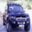

In [64]:
net:evaluate()   --turn off dropout

print(classes[testset.label[10]])
itorch.image(testset.data[10])
predicted = net:forward(testset.data[10]:view(1,3,32,32):cuda())

In [65]:
-- the output of the network is Log-Probabilities. To convert them to probabilities, you have to take e^x 
print(predicted:exp())

Columns 1 to 6
 4.6548e-03  9.0047e-01  3.7331e-05  1.9772e-05  4.8709e-06  2.5659e-06

Columns 7 to 10
 9.4628e-05  1.6155e-06  4.9786e-03  8.9737e-02
[torch.CudaTensor of size 1x10]




You can see the network predictions. The network assigned a probability to each classes, given the image.

To make it clearer, let us tag each probability with it's class-name:

In [66]:
for i=1,predicted:size(2) do
    print(classes[i],predicted[1][i])
end
preds= predicted[1]:float()
Plot._data = {}
line = torch.linspace(0,9,10)
Plot:quad(line,torch.zeros(#classes),line+1,preds,'red',classes):xaxis('class #'):yaxis("Prob(class)"):title('Classification'):draw()

airplane	0.0046548135578632	
automobile	0.90046828985214	
bird	3.7330541090341e-05	
cat	1.9772005543928e-05	
deer	4.8709125621826e-06	
dog	2.5659192033345e-06	
frog	9.4628165243194e-05	
horse	1.6155047433131e-06	
ship	0.0049785524606705	
truck	0.08973740041256	


Alright, fine. Thats one single example, but how many in total seem to be correct over the test set?

We will use optim's confusion matrix method, to evaluate over all test set samples.

In [21]:
confusionMatrix = optim.ConfusionMatrix(classes)
indexes = torch.range(1,testset.data:size(1)-batchSize, batchSize)

net:evaluate()

for i=1,indexes:size(1) do
    local idx = indexes[i]
    x  = testset.data:narrow(1,idx,batchSize):cuda()
    yt = testset.label:narrow(1,idx,batchSize):cuda()
    local y = net:forward(x)
    confusionMatrix:batchAdd(y,yt)
end

print(tostring(confusionMatrix))
    

ConfusionMatrix:
[[     726      23      74      17      18       0       7      10      92      31]   72.745% 	[class: airplane]
 [      32     828      12      10       1       2       9       2      31      72]   82.883% 	[class: automobile]
 [      63       5     710      41      71      31      34      17      17      10]   71.071% 	[class: bird]
 [      29      14     157     478      75     101      75      30      25      13]   47.944% 	[class: cat]
 [      26       4     173      37     637      11      32      58      17       5]   63.700% 	[class: deer]
 [      17       8     141     191      48     496      24      47      16       9]   49.749% 	[class: dog]
 [       7       0     108      45      44       7     771       4      13       1]   77.100% 	[class: frog]
 [      21       2     109      28      74      40       1     700       8      14]   70.211% 	[class: horse]
 [      57      29      13      10       3       1       5       1     846      32]   84.855% 	[class:

That looks waaay better than chance, which is 10% accuracy (randomly picking a class out of 10 classes). Seems like the network learnt something.

##Visualizing Network Weights+Activations
We can reach every value at each layer (output,weight,gradients) and visualize them.

We get a layer and values using:

In [48]:
layer6 = net:get(6)

layer6_weights = layer6.weights -- Getting the weights
layer6_output = layer6.output -- Getting the output

So visualizing the 1st layer weights is as simple as (scaling up so we can see anything):

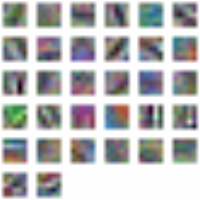

In [49]:
Weights_1st_Layer = net:get(1).weight
scaledWeights = image.scale(image.toDisplayTensor({input=Weights_1st_Layer,padding=2}),200)
itorch.image(scaledWeights)

And to visualize network activation, we will feed another sample and examine the output of each layer

Input Image	


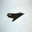

Layer 	1	cudnn.SpatialConvolution	


Layer 	2	cudnn.SpatialMaxPooling	


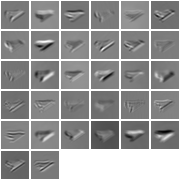

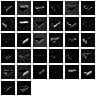

Layer 	3	cudnn.ReLU	


Layer 	4	nn.SpatialBatchNormalization	


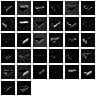

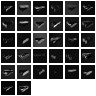

Layer 	5	cudnn.SpatialConvolution	


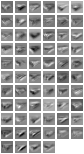

Layer 	6	cudnn.SpatialMaxPooling	


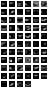

Layer 	7	cudnn.ReLU	


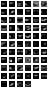

Layer 	8	nn.SpatialBatchNormalization	


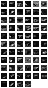

Layer 	9	cudnn.SpatialConvolution	


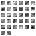

In [60]:
print('Input Image')
itorch.image(testset.data[500])
net:forward(testset.data[500]:view(1,3,32,32):cuda())
for l=1,9 do
  print('Layer ' ,l, tostring(net:get(l)))
  layer_output = net:get(l).output[1]
  itorch.image(layer_output)
end

**Goals achieved:**
* Understand torch and the neural networks package at a high-level.
* Train a small neural network on CPU and GPU

### Where do I go next?

* Build crazy graphs of networks: https://github.com/torch/nngraph
* Train on imagenet with multiple GPUs: https://github.com/soumith/imagenet-multiGPU.torch
* Train recurrent networks with LSTM on text: https://github.com/wojzaremba/lstm

* More demos and tutorials: https://github.com/torch/torch7/wiki/Cheatsheet

* Chat with developers of Torch: http://gitter.im/torch/torch7
* Ask for help: http://groups.google.com/forum/#!forum/torch7
